# Trajectory

The data is taken from Microsoft and it contains the GPS data from close to 8000 taxis. The data is collected every 177 seconds and we have the data for a week.

The data is in txt files in the format given below:

Taxi Id (integer), Date time, Longitude (degrees), Latitude (degrees)

Eg:
```
1,2008-02-03 14:37:29,117.41246,39.82771
```

# Goal

1. Read data
2. Find the time interval
3. Find the distance interval
4. Histograms of time and distance intervals
5. Density distribution of location
6. Plot the trip

In [1]:
from pykalman import KalmanFilter
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/pandas/io/excel.py:626: UserWarning: Installed openpyxl is not supported at this time. Use >=1.6.1 and <2.0.0.
  .format(openpyxl_compat.start_ver, openpyxl_compat.stop_ver))


In [2]:
from matplotlib.ticker import LogFormatter 
class logFormat(LogFormatter):
    def __call__(self, v, pos=None):
        vv = self._base ** v
        return LogFormatter.__call__(self, vv, pos) 
def distmeasure(latInput, lonInput):
    latitude = np.array(latInput)
    longitude = np.array(lonInput)  
    latitude *= np.pi/180
    longitude *= np.pi/180  
    longitude1 = longitude[0:-1]
    longitude2 = longitude[1:] 
    latitude1 = latitude[0:-1]
    latitude2 = latitude[1:]
    xCoor = (longitude2-longitude1) * np.cos((latitude1+latitude2)/2)
    yCoor = latitude2-latitude1
    distance = np.sqrt(xCoor**2 + yCoor**2) * 6371*1000
    return distance

def fetchFiles(directory):
    fullFile = []
    for root, dirs, files in os.walk(directory):
        for name in files:
            fullFile.append(os.path.join(root, name))       
    return fullFile

## Read in the data 

The data folders are stored in the `data` folder. Each `.txt` file contains data for one taxi. 

In [3]:
full_files = fetchFiles('data')
print "Reading all data files"
df = []
for index, file_path in enumerate(full_files):
    df.append(pd.read_csv(file_path, infer_datetime_format=True,header=None, parse_dates = [1],names = ['taxi_id', 'date_time', 'longitude', 'latitude']))
df = pd.concat(df, ignore_index=True)
print "Size of data: ", df.shape
print "%.1f million rows" % (df.shape[0]/1.0e6)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

Reading all data files
Size of data:  (12217254, 4)
12.2 million rows


# Time Intervals

In [4]:
print "Calculating the interval of time between data samples"
grouped = df.sort('date_time').groupby('taxi_id')['date_time']
timeInt = []
for group_id, times in grouped:
    timeInt.append(times.diff())
timeInt = pd.concat(timeInt)
timeInt.dropna(inplace=True)
#print timeInt.isnull().values.sum()
timeInt /= np.timedelta64(1,'s')
print "Average time interval: %.0f secs" % timeInt[timeInt < 1e4].mean()
timeInt /= 60

Calculating the interval of time between data samples
0
Average time interval: 273 secs


In [5]:
print "Calculating the interval of distance between data samples"
grouped = df.sort('date_time').groupby('taxi_id')
distances = []
for g in grouped:
    distances.append(pd.DataFrame(distmeasure(g[1].latitude.values,g[1].longitude.values)))
distances = pd.concat(distances)
print "Total distance: %.0f million km" % (distances[distances[0] < 1e5][0].sum()/1e9)
print "Average distance interval: %.0f m" % (distances[(distances[0] < 1e5)][0].mean())

Calculating the interval of distance between data samples
Total distance: 9 million km
Average distance interval: 827 m


Time interval plot


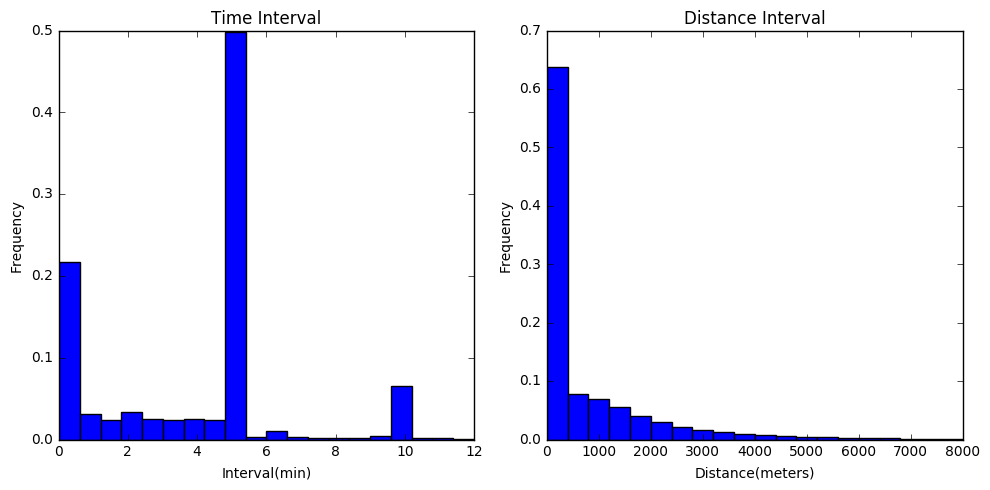

In [6]:
print "Time interval plot"
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].set_xlabel('Interval(min)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Time Interval')
hist, bins = np.histogram(timeInt[(timeInt > 0) & (timeInt < 12)].astype(np.ndarray), bins=20)
axes[0].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
distances.dropna(inplace=True)
hist, bins = np.histogram(distances[distances[0] < 8000][0].values, bins=20)
axes[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
axes[1].set_xlabel('Distance(meters)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distance Interval')
fig.tight_layout()

# Position density

Density is plotted as a function of latitude and longitude. 
The data mostly lie on major roads and highways. 

## Beijing Overview

Position density


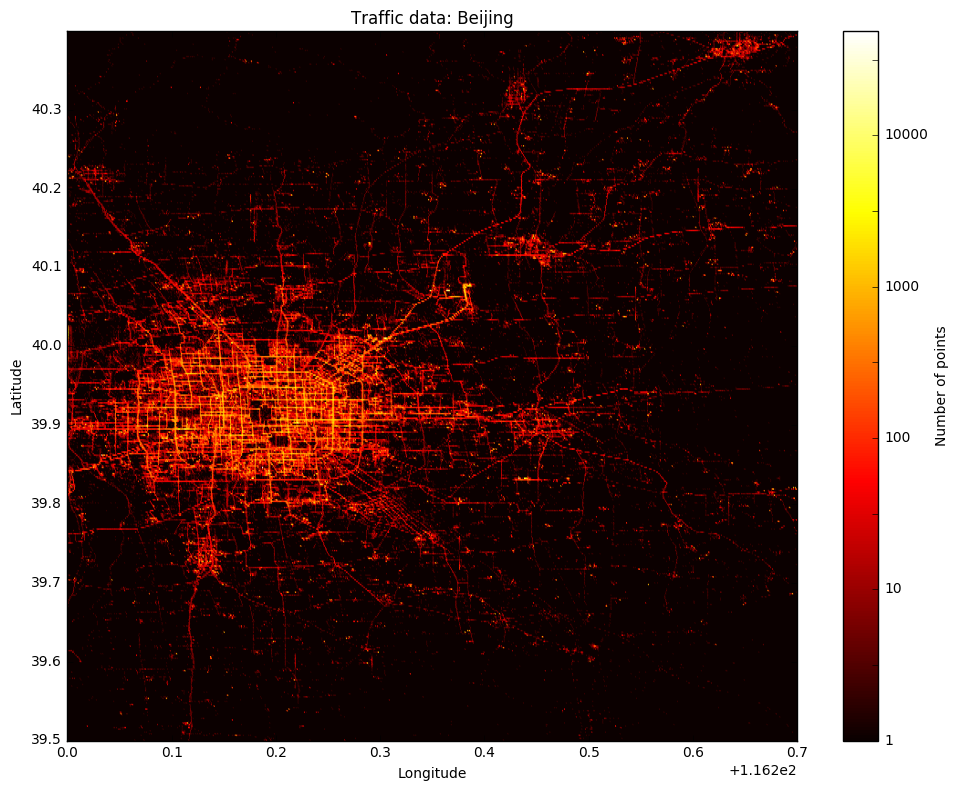

In [7]:
print "Position density"
xmin, xmax = 116.2, 116.9
ymin, ymax = 39.5, 40.4
window = df[(xmin < df.longitude) & (df.longitude < xmax) & (ymin < df.latitude) & (df.latitude < ymax)]
x = np.array(window.longitude)
y = np.array(window.latitude)
plt.figure(figsize = (10,8), dpi=200)
plt.hexbin(x,y,bins='log', gridsize=800, cmap=plt.cm.hot)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data: Beijing")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cb = plt.colorbar(format=logFormat())
cb.set_label('Number of points')
plt.tight_layout()
plt.show()

## 5th Ring Road, Beijing
This plot provides a detailed look at the city. 

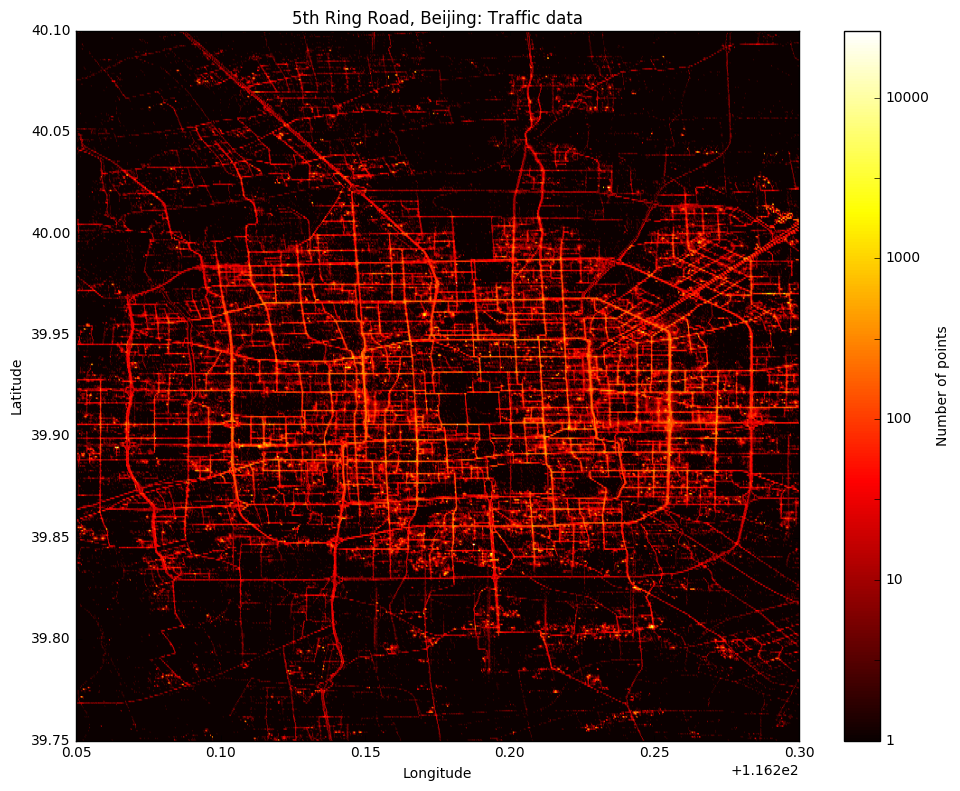

In [8]:
xmin, xmax = 116.25, 116.5
ymin, ymax = 39.75, 40.1
window = df[(xmin < df.longitude) & (df.longitude < xmax) & (ymin < df.latitude) & ( df.latitude < ymax)]
x = np.array(window.longitude)
y = np.array(window.latitude)
plt.figure(figsize = (10,8), dpi=200)
plt.hexbin(x,y, bins='log', gridsize=800, cmap=plt.cm.hot)
plt.axis([xmin, xmax, ymin, ymax])
plt.title("5th Ring Road, Beijing: Traffic data")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
cb = plt.colorbar(format=logFormat())
cb.set_label('Number of points')
plt.tight_layout()
plt.show()

To identify a trip, I manually plotted the distance intervals and defined a trip as starting with 0 speed and ending with 0 speed. 

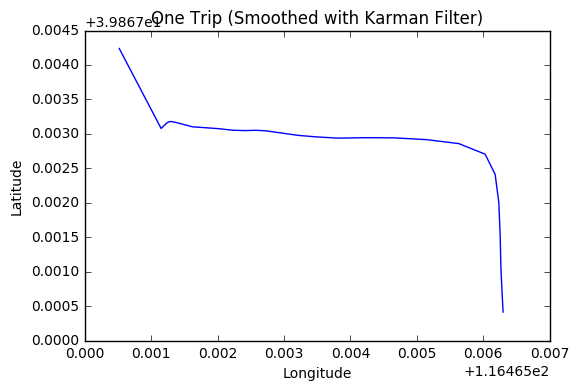

In [9]:
one_taxi = df[df.taxi_id == 1131]
start_index = 38
end_index = 69
measurements = np.asarray([one_taxi.longitude, one_taxi.latitude])
measurements = measurements.T[start_index:end_index]
kf = KalmanFilter(initial_state_mean = measurements[0],n_dim_obs=2, n_dim_state=2)
kf = kf.em(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
plt.plot(smoothed_state_means.T[0],smoothed_state_means.T[1])
plt.title("One Trip (Smoothening with Karman Filter)")
plt.xlabel('Longitude')
plt.ylabel('Latitude')

To give a sense of the larger picture, I plot one taxi's trajectory over a longer time span.

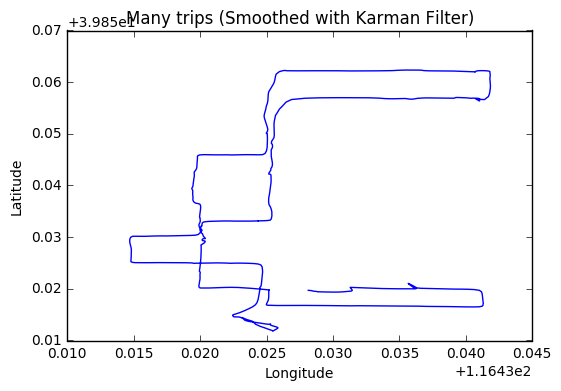

In [10]:
one_taxi = df[df.taxi_id == 1131]

start_index = 0
end_index = 800

measurements = np.asarray([one_taxi.longitude, one_taxi.latitude])
measurements = measurements.T[start_index:end_index]
kf = KalmanFilter(initial_state_mean = measurements[0],n_dim_obs=2, n_dim_state=2)
kf = kf.em(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
plt.plot(smoothed_state_means.T[0],smoothed_state_means.T[1])
plt.title("Many trips (Smoothening with Karman Filter)")
plt.xlabel('Longitude')
plt.ylabel('Latitude')